## Koronavírusos esetek Magyarországon
Adatforrás [itt](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)!

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

DATA_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
FILE_C = "time_series_19-covid-Confirmed.csv"
FILE_D = "time_series_19-covid-Deaths.csv"
FILE_R = "time_series_19-covid-Recovered.csv"

In [89]:
def load_data(the_file):
    data = pd.read_csv(the_file)
    lowercase = lambda x: str(x).lower()
    data.rename(lowercase, axis="columns", inplace=True)
    data.rename(columns={'long': 'lon', 'country/region':'country', 'province/state':'state'}, inplace=True)
    data.fillna(0, inplace=True)
    data = data[data['country'] == 'Hungary']
    data = data.set_index('country', drop=True)
    data = data.iloc[:,4:].T
    data = data[(data.T != 0).any()]
    return data
df_d = load_data(DATA_URL + FILE_D)
df_r = load_data(DATA_URL + FILE_R)
df_c = load_data(DATA_URL + FILE_C)

Dataset date: 3/12/20


In [90]:
df = pd.DataFrame()
df['Eset'] = df_c['Hungary']
df['Gyógyult'] = df_r['Hungary']
df['Halott'] = df_d['Hungary']
df.fillna(0, axis=0, inplace= True)
df

,Eset,Gyógyult,Halott
3/4/20,2,0.0,0.0
3/5/20,2,0.0,0.0
3/6/20,2,0.0,0.0
3/7/20,4,0.0,0.0
3/8/20,7,0.0,0.0
3/9/20,9,0.0,0.0
3/10/20,9,0.0,0.0
3/11/20,13,0.0,0.0
3/12/20,13,0.0,0.0
3/13/20,19,0.0,0.0


### Aktuális adatok a [magyar](koronavirus.gov.hu) oldalról

In [91]:
from bs4 import BeautifulSoup as bs
import requests
url='https://koronavirus.gov.hu/'
page = requests.get(url)

In [92]:
soup = bs(page.content, 'html.parser')

In [93]:
c = soup.find_all(class_ = 'number')
eset = int(c[0].text)
gyogyult = int(c[1].text)
halott = int(c[2].text)

In [94]:
import datetime as datetime
now = datetime.datetime.today()
now = str(now.month)+'/'+str(now.day)+'/'+str(now.year)[2:]
now

'3/14/20'

In [95]:
dfT = df.T
dfT[now] = [eset, gyogyult, halott]
df = dfT.T
df

,Eset,Gyógyult,Halott
3/4/20,2.0,0.0,0.0
3/5/20,2.0,0.0,0.0
3/6/20,2.0,0.0,0.0
3/7/20,4.0,0.0,0.0
3/8/20,7.0,0.0,0.0
3/9/20,9.0,0.0,0.0
3/10/20,9.0,0.0,0.0
3/11/20,13.0,0.0,0.0
3/12/20,13.0,0.0,0.0
3/13/20,19.0,0.0,0.0


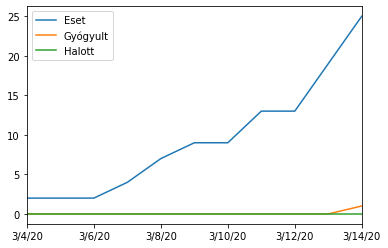

In [97]:
df.plot()